# Machine Translation
#### Maria García y Miren Ostolaza
El objetivo se esta práctica será generar un modelo capaz de hacer traducciones de texto de español a inglés utilizando redes neuronales.

### Import Required Libraries

A continuación se cargan las librerías necesarias para llevar a cabo la práctica.

In [2]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)


import collections
 
import helper
import numpy as np
 
 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

UsageError: Line magic function `%` not found.


In [35]:
from keras.layers import GRU, Input, Dense, TimeDistributed, Dropout, LSTM
from keras.models import Model, Sequential
from keras.layers import Activation
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

### Read Data

Lo primero será leer nuestro fichero de texto, que en este caso contiene oraciones traducidas del español al inglés. Para ello se define la siguiente función:

In [3]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Para diferenciar cada oración se separa el texto en líneas:

In [4]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [5]:
data = read_text("spa-eng\spa.txt")
lineas = to_lines(data)


In [6]:
print(lineas[:10])

[['Go.', 'Ve.', 'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'], ['Go.', 'Vete.', 'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'], ['Go.', 'Vaya.', 'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'], ['Go.', 'Váyase.', 'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #6586271 (arh)'], ['Hi.', 'Hola.', 'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #431975 (Leono)'], ['Run!', '¡Corre!', 'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1685404 (Elenitigormiti)'], ['Run!', '¡Corran!', 'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #5213896 (cueyayotl)'], ['Run!', '¡Corra!', 'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #8005613 (Seael)'], ['Run!', '¡Corred!', 'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #8005615 (Seael)'], ['Run.', 'Corred.', 'CC-BY 2.0 (France) Attribution: tatoeba.o

Antes de seguir será recomendable deshacernos de la información que no nos aporta nada de cada linea

In [7]:
for linea in lineas:
   
      del linea[-1]

In [8]:
print(lineas[:10])

[['Go.', 'Ve.'], ['Go.', 'Vete.'], ['Go.', 'Vaya.'], ['Go.', 'Váyase.'], ['Hi.', 'Hola.'], ['Run!', '¡Corre!'], ['Run!', '¡Corran!'], ['Run!', '¡Corra!'], ['Run!', '¡Corred!'], ['Run.', 'Corred.']]


In [9]:
spa_eng = array(lineas)



A modo de simplificar el problema y reducir el tiempo de ejecución de entrenamiento de los modelos se seleccionan unicamente los primeros 50000 oraciones.

In [10]:
spa_eng = spa_eng[:50000,:]

### Text Pre-Processing

#### Text Cleaning

In [11]:
spa_eng

array([['Go.', 'Ve.'],
       ['Go.', 'Vete.'],
       ['Go.', 'Vaya.'],
       ...,
       ['I am waiting for my driver.', 'Estoy esperando a mi chofer.'],
       ['I appreciate all your help.', 'Aprecio toda tu ayuda.'],
       ['I appreciate your interest.', 'Agradezco tu interés.']],
      dtype='<U332')

Para poder trabajar con los datos se eliminan los signos de puntuación y se convierten a minúsculas todas las letras.

In [12]:
# Remove punctuation
spa_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,0]]
spa_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in spa_eng[:,1]]

In [13]:
spa_eng

array([['Go', 'Ve'],
       ['Go', 'Vete'],
       ['Go', 'Vaya'],
       ...,
       ['I am waiting for my driver', 'Estoy esperando a mi chofer'],
       ['I appreciate all your help', 'Aprecio toda tu ayuda'],
       ['I appreciate your interest', 'Agradezco tu interés']],
      dtype='<U332')

In [14]:
# convert to lowercase
for i in range(len(spa_eng)):
    spa_eng[i,0] = spa_eng[i,0].lower()
    
    spa_eng[i,1] = spa_eng[i,1].lower()

In [15]:
spa_eng

array([['go', 've'],
       ['go', 'vete'],
       ['go', 'vaya'],
       ...,
       ['i am waiting for my driver', 'estoy esperando a mi chofer'],
       ['i appreciate all your help', 'aprecio toda tu ayuda'],
       ['i appreciate your interest', 'agradezco tu interés']],
      dtype='<U332')

#### Text to Sequence Conversion

Se calculan las longitudes de las oraciones de los dos idiomas.

In [16]:
# empty lists
eng_l = []
spa_l = []

# populate the lists with sentence lengths
for i in spa_eng[:,0]:
    eng_l.append(len(i.split()))

for i in spa_eng[:,1]:
    spa_l.append(len(i.split()))

In [17]:
length_df = pd.DataFrame({'eng':eng_l, 'spa':spa_l})
print(length_df)
print(max(length_df.eng))
print(max(length_df.spa))

       eng  spa
0        1    1
1        1    1
2        1    1
3        1    1
4        1    1
...    ...  ...
49995    6    5
49996    8    6
49997    6    5
49998    5    4
49999    4    3

[50000 rows x 2 columns]
8
12


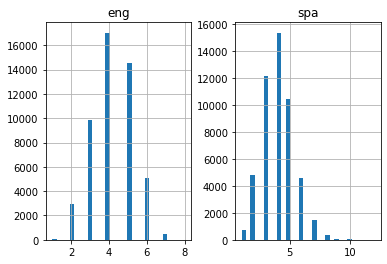

In [18]:
length_df.hist(bins = 30)
plt.show()

Se ha podido ver que la mayor longitud recogida en una oración en castellano ha sido 12, y en el caso del inglés de 8. Utilizaremos estos valores posteriormente en la generación de modelos.

Un paso importante parte del preprocesamiento de textos es la tokenización,que permite vectorizar un corpus de texto, convirtiendo cada frase en una secuencia de enteros Luego rellenaremos esas secuencias con ceros para que todas las secuencias tengan la misma longitud.

In [19]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [20]:
# prepare english tokenizer
eng_tokenizer = tokenization(spa_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6942


In [21]:
# prepare spanish tokenizer
spa_tokenizer = tokenization(spa_eng[:, 1])
spa_vocab_size = len(spa_tokenizer.word_index) + 1

spa_length = 8
print('Spanish Vocabulary Size: %d' % spa_vocab_size)

Spanish Vocabulary Size: 14196


In [22]:
print(spa_tokenizer.word_counts)

OrderedDict([('ve', 115), ('vete', 30), ('vaya', 41), ('váyase', 7), ('hola', 12), ('¡corre', 1), ('¡corran', 1), ('¡corra', 1), ('¡corred', 1), ('corred', 1), ('¿quién', 380), ('¡órale', 10), ('¡fuego', 4), ('¡incendio', 1), ('¡disparad', 3), ('¡ayuda', 2), ('¡socorro', 1), ('¡auxilio', 2), ('¡salta', 1), ('salte', 2), ('¡parad', 1), ('¡para', 4), ('¡pare', 1), ('¡espera', 4), ('esperen', 10), ('continúa', 14), ('continúe', 6), ('corrí', 13), ('corría', 4), ('lo', 2116), ('intento', 8), ('¡he', 2), ('ganado', 16), ('¡oh', 3), ('no', 5878), ('tomátelo', 2), ('con', 871), ('soda', 3), ('¡disparen', 1), ('¡dispara', 1), ('¡dispará', 1), ('¡dispare', 1), ('sonríe', 5), ('¡al', 2), ('ataque', 5), ('¡atacad', 1), ('¡ataque', 1), ('¡ataquen', 1), ('¡ataca', 1), ('levanta', 23), ('ahora', 489), ('mismo', 129), ('id', 6), ('vayan', 11), ('ya', 339), ('¡lo', 10), ('tengo', 876), ('¿lo', 63), ('pillas', 1), ('¿entendiste', 2), ('él', 2559), ('corrió', 23), ('métete', 3), ('adentro', 26), ('abráz

A continuación se define una función que codificca las frases y añade valores hasta una longitud máxima de frase como se ha mencionado anteriormente. 

In [23]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

### Model Building

Antes de empezar construir modelos, se divide el dataset en entrenamiento y validación con una proporión de 80% 20% respectivamente.

In [24]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(spa_eng, test_size=0.2, random_state = 12)

A continuación se codifican las frases en español como secuencias de entrada y las frases en inglés como secuencias de salida utilizando función definida previamente.

In [25]:
# prepare training data
trainX = encode_sequences(spa_tokenizer, spa_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[   1   10 1574 ...    0    0    0]
 [4836    4    6 ...    0    0    0]
 [  14 4963    0 ...    0    0    0]
 ...
 [  43  199 1665 ...    0    0    0]
 [  18   12   15 ...    8 1196    0]
 [   2  240 1475 ...    0    0    0]]
40000
[[   3  182   10 ...    0    0    0]
 [   1 1094    6 ...    0    0    0]
 [  50  101    9 ...    0    0    0]
 ...
 [  44  444  432 ...    0    0    0]
 [  22    4  123 ...  213    0    0]
 [   1  202 2244 ...    0    0    0]]
40000


In [26]:
print(trainX.shape)
print(trainY.shape)

(40000, 8)
(40000, 8)


In [27]:
# prepare validation data
testX = encode_sequences(spa_tokenizer, spa_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[  53   43   28 ...    0    0    0]
 [ 233    4    1 ...    0    0    0]
 [ 108 8599    0 ...    0    0    0]
 ...
 [9604  115  974 ...    0    0    0]
 [1347   55  598 ...    0    0    0]
 [   2   31 6750 ...    0    0    0]]
10000
[[  36   16   40 ...    0    0    0]
 [   1   37    3 ...    0    0    0]
 [   2   99 1339 ...    0    0    0]
 ...
 [  56 1781   29 ...    0    0    0]
 [  33    2  217 ...    0    0    0]
 [   1  867   42 ...    0    0    0]]
10000


In [28]:
print(testX.shape)
print(testY.shape)

(10000, 8)
(10000, 8)


# Seq2Seq

Con los datos preporcesados y la división hecha en el dataset, se puede empezar a generar modelos capaces de cumplir con el objetivo del problema.

Primero se contruye un modelo con una arquitectura de Seq2Seq. Para ello, se genera un modelo de redes neuronales recurrentes (RNN) compuesto por una capa de embedding, y LSTM como encoder y otra de LSTM seguida por una capa densa como decoder.  

In [29]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

 Se hace uso del optimizador RMSprop con una tasa de aprendizaje de 0.001. E Lo consigue este optimizador incluye:

- Mantener una media móvil (descontada) del cuadrado de los gradientes
- Dividir el gradiente por la raíz de esta media

In [30]:
print(spa_vocab_size)
print(eng_vocab_size)
print(spa_length)
print(eng_length)

14196
6942
8
8


In [37]:
model = build_model(spa_vocab_size, eng_vocab_size, spa_length, eng_length, 512)
learning_rate = 0.001
model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 8, 512)            7268352   
_________________________________________________________________
lstm_8 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 8, 512)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 8, 512)            2099200   
_________________________________________________________________
dense_4 (Dense)              (None, 8, 6942)           3561246   
Total params: 15,027,998
Trainable params: 15,027,998
Non-trainable params: 0
_________________________________________________________________



Se ha utilizado __'sparse_categorical_crossentropy'__ como función de pérdida porque permite utilizar la secuencia objetivo tal y como es en lugar de un formato codificado en caliente. Ejecutar **One Hot Enconding** de las secuencias objetivo con un vocabulario tan grande podría consumir toda la memoria de nuestro sistema.


Se empieza a entrenar el modelo teniendo en cuenta los siguientes hiperparámetros:
    - Epoch=20
    - Batch Size = 512

In [40]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=20, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Epoch 1/20
63/63 [==============================] - 217s 3s/step - loss: 4.3640 - accuracy: 0.4829 - val_loss: 3.5769 - val_accuracy: 0.4968

Epoch 00001: val_loss improved from inf to 3.57686, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 2/20
63/63 [==============================] - 216s 3s/step - loss: 3.4058 - accuracy: 0.5001 - val_loss: 3.3773 - val_accuracy: 0.5044

Epoch 00002: val_loss improved from 3.57686 to 3.37730, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 3/20
63/63 [==============================] - 224s 4s/step - loss: 3.2635 - accuracy: 0.5076 - val_loss: 3.2976 - val_accuracy: 0.5047

Epoch 00003: val_loss improved from 3.37730 to 3.29761, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 4/20
63/63 [==============================] - 243s 4s/step - loss: 3.1849 - accuracy: 0.5108 - val_loss: 3.2507 - val_accuracy: 0.5101

Epoch 00004: val_loss improved from 3.29761 to 3.25070, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 5/20
63/63 [==============================] - 240s 4s/step - loss: 3.1315 - accuracy: 0.5130 - val_loss: 3.2286 - val_accuracy: 0.5112

Epoch 00005: val_loss improved from 3.25070 to 3.22859, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 6/20
63/63 [==============================] - 243s 4s/step - loss: 3.0773 - accuracy: 0.5188 - val_loss: 3.1775 - val_accuracy: 0.5192

Epoch 00006: val_loss improved from 3.22859 to 3.17750, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 7/20
63/63 [==============================] - 241s 4s/step - loss: 3.0132 - accuracy: 0.5274 - val_loss: 3.1295 - val_accuracy: 0.5242

Epoch 00007: val_loss improved from 3.17750 to 3.12946, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 8/20
63/63 [==============================] - 250s 4s/step - loss: 2.9528 - accuracy: 0.5325 - val_loss: 3.0850 - val_accuracy: 0.5293

Epoch 00008: val_loss improved from 3.12946 to 3.08498, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 9/20
63/63 [==============================] - 249s 4s/step - loss: 2.8988 - accuracy: 0.5361 - val_loss: 3.0488 - val_accuracy: 0.5320

Epoch 00009: val_loss improved from 3.08498 to 3.04876, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 10/20
63/63 [==============================] - 241s 4s/step - loss: 2.8396 - accuracy: 0.5406 - val_loss: 3.0027 - val_accuracy: 0.5357

Epoch 00010: val_loss improved from 3.04876 to 3.00266, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 11/20
63/63 [==============================] - 237s 4s/step - loss: 2.7681 - accuracy: 0.5472 - val_loss: 2.9410 - val_accuracy: 0.5432

Epoch 00011: val_loss improved from 3.00266 to 2.94101, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 12/20
63/63 [==============================] - 245s 4s/step - loss: 2.6821 - accuracy: 0.5572 - val_loss: 2.8712 - val_accuracy: 0.5522

Epoch 00012: val_loss improved from 2.94101 to 2.87124, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 13/20
63/63 [==============================] - 238s 4s/step - loss: 2.5844 - accuracy: 0.5691 - val_loss: 2.7928 - val_accuracy: 0.5648

Epoch 00013: val_loss improved from 2.87124 to 2.79281, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 14/20
63/63 [==============================] - 240s 4s/step - loss: 2.4810 - accuracy: 0.5821 - val_loss: 2.7150 - val_accuracy: 0.5752

Epoch 00014: val_loss improved from 2.79281 to 2.71502, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 15/20
63/63 [==============================] - 239s 4s/step - loss: 2.3775 - accuracy: 0.5935 - val_loss: 2.6600 - val_accuracy: 0.5844

Epoch 00015: val_loss improved from 2.71502 to 2.65998, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 16/20
63/63 [==============================] - 240s 4s/step - loss: 2.2778 - accuracy: 0.6041 - val_loss: 2.5649 - val_accuracy: 0.5930

Epoch 00016: val_loss improved from 2.65998 to 2.56486, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 17/20
63/63 [==============================] - 249s 4s/step - loss: 2.1730 - accuracy: 0.6153 - val_loss: 2.4998 - val_accuracy: 0.6027

Epoch 00017: val_loss improved from 2.56486 to 2.49981, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 18/20
63/63 [==============================] - 256s 4s/step - loss: 2.0702 - accuracy: 0.6276 - val_loss: 2.4299 - val_accuracy: 0.6113

Epoch 00018: val_loss improved from 2.49981 to 2.42993, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 19/20
63/63 [==============================] - 244s 4s/step - loss: 1.9674 - accuracy: 0.6407 - val_loss: 2.3582 - val_accuracy: 0.6211

Epoch 00019: val_loss improved from 2.42993 to 2.35819, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Epoch 20/20
63/63 [==============================] - 265s 4s/step - loss: 1.8656 - accuracy: 0.6551 - val_loss: 2.2949 - val_accuracy: 0.6283

Epoch 00020: val_loss improved from 2.35819 to 2.29489, saving model to model.h1.24_jan_19


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


INFO:tensorflow:Assets written to: model.h1.24_jan_19\assets


Let's compare the training loss and the validation loss.

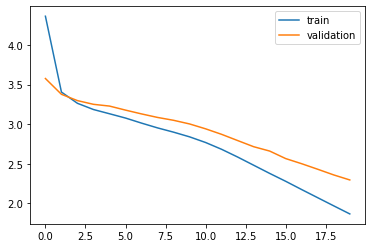

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

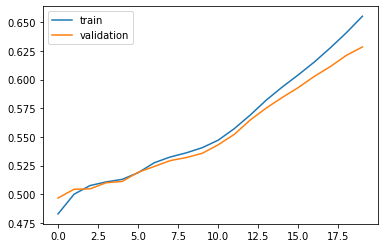

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','validation'])
plt.show()

Se puede ver que este primer modelo ha conseguido un accuracy de 0.6551 y un val_accuracy de 0.6283. Parece que este valor aumenta a medida que trancurren las épocas, por lo que es muy probable que al aumentar ese valor tambien se consiga una mejor precisión del modelo. Sin embargo, esto requeriría un mayor tiempo de ejecución así que se debe ver si realmente estamos dispuestos a ello o si el resultado obtenido es lo suficientemente bueno para nuesro caso. 

## Simple RNN

Se quiere ver si con un modelo más sencillo los resultados serán similares al modelo anterior. Para ello, se define el siguiente modelo RNN con una capa LSTM.

Se mantienen los hiperparámetros fijados en el apartado anterior, pero en este caso el optimizador que se utilizará es Adam.La optimización de Adam es un método de descenso de gradiente estocástico que se basa en la estimación adaptativa de momentos de primer y segundo orden.

In [32]:
def simple_model(input_shape, output_sequence_length, spanish_vocab_size, english_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers
    learning_rate = 0.001
    spanish_input = Input(shape=input_shape[1:], name="input_layer")    # the shape is (input length x 1) as batchsize excluded
    
    # LSTM takes as input (batchsize,input_length,1) and outputs (batchsize, input_length, 64) because return-seq=True
    x = LSTM(64, return_sequences=True, activation="tanh", name="LSTM_layer")(spanish_input)
    preds = TimeDistributed(Dense(english_vocab_size, activation="softmax"), name="Dense_layer")(x)
    model = Model(inputs=spanish_input, outputs=preds, name='simple_LSTM')
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    
    return model

In [138]:
tmp_x = trainX.reshape((trainX.shape[0],trainX.shape[1],1))  # reshape as 3D (batchsize, timesteps, 1) for LSTM input

# Train the neural network
simple_rnn_model = simple_model(
    tmp_x.shape,
    max_spanish_sequence_length,
    eng_vocab_size,
    spa_vocab_size)

simple_rnn_model.summary()

simpleRNN = simple_rnn_model.fit(tmp_x, trainY, batch_size=512, epochs=20, validation_split=0.2)

Model: "simple_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 8, 1)]            0         
_________________________________________________________________
LSTM_layer (LSTM)            (None, 8, 64)             16896     
_________________________________________________________________
Dense_layer (TimeDistributed (None, 8, 14196)          922740    
Total params: 939,636
Trainable params: 939,636
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
63/63 [==============================] - 174s 3s/step - loss: 8.7548 - accuracy: 0.3961 - val_loss: 4.9418 - val_accuracy: 0.4738
Epoch 2/20
63/63 [==============================] - 179s 3s/step - loss: 4.2959 - accuracy: 0.4748 - val_loss: 3.7704 - val_accuracy: 0.4738
Epoch 3/20
63/63 [==============================] - 180s 3s/step - loss: 3.7038 - accuracy: 0.475

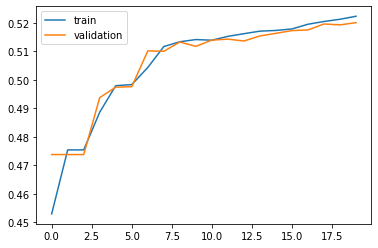

In [139]:
plt.plot(simpleRNN.history['accuracy'])
plt.plot(simpleRNN.history['val_accuracy'])
plt.legend(['train','validation'])
plt.show()

Con este modelo simple se ha obtenido un accuracy de 0.5226, similar en el conjunto de entrenamiento y en el de validación, y con un incremento proporcional al número de épocas del modelo.

## RNN with GRU layer

Con el fin de mejorar el accuray del modelo previo, se ha decidido ver el efecto que tendría añadir capas GRU manteniendo los hiperparámetros constantes.

In [69]:
from keras.layers import GRU, Input, Dense, TimeDistributed, Dropout, LSTM
from keras.models import Model, Sequential
from keras.layers import Activation
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
def gru_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers
    learning_rate = 1e-3
    model = Sequential()
    model.add(GRU(128, input_shape=input_shape[1:], return_sequences=True))
    model.add(Dropout(0.5))
    model.add(GRU(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(256, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax'))) 
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])

    return model 

In [74]:
tmp_y = trainY.reshape((trainY.shape[0],trainY.shape[1],1))
 
max_english_sequence_length=max(length_df.eng)
max_spanish_sequence_length=max(length_df.spa)

In [75]:
print(tmp_y.shape)
print(trainX.shape)


(40000, 8, 1)
(40000, 8)


In [76]:
# Train the neural network
gru_rnn_model = gru_model(
    tmp_y.shape,
    max_spanish_sequence_length,
    eng_vocab_size,
    spa_vocab_size)
gru = gru_rnn_model.fit(tmp_y, trainX, batch_size=256, epochs=20, validation_split=0.2)

Epoch 1/20
125/125 [==============================] - 235s 2s/step - loss: 5.7880 - accuracy: 0.4512 - val_loss: 3.7763 - val_accuracy: 0.4969
Epoch 2/20
125/125 [==============================] - 214s 2s/step - loss: 3.7483 - accuracy: 0.5041 - val_loss: 3.6380 - val_accuracy: 0.5123
Epoch 3/20
125/125 [==============================] - 202s 2s/step - loss: 3.6282 - accuracy: 0.5111 - val_loss: 3.5803 - val_accuracy: 0.5152
Epoch 4/20
125/125 [==============================] - 213s 2s/step - loss: 3.5530 - accuracy: 0.5159 - val_loss: 3.5323 - val_accuracy: 0.5197
Epoch 5/20
125/125 [==============================] - 219s 2s/step - loss: 3.4902 - accuracy: 0.5194 - val_loss: 3.5058 - val_accuracy: 0.5221
Epoch 6/20
125/125 [==============================] - 211s 2s/step - loss: 3.4630 - accuracy: 0.5208 - val_loss: 3.4827 - val_accuracy: 0.5297
Epoch 7/20
125/125 [==============================] - 204s 2s/step - loss: 3.4247 - accuracy: 0.5228 - val_loss: 3.4533 - val_accuracy: 0.5270

In [109]:
gru_rnn_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_11 (GRU)                 (None, 8, 128)            50304     
_________________________________________________________________
dropout_15 (Dropout)         (None, 8, 128)            0         
_________________________________________________________________
gru_12 (GRU)                 (None, 8, 128)            99072     
_________________________________________________________________
dropout_16 (Dropout)         (None, 8, 128)            0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 8, 256)            33024     
_________________________________________________________________
dropout_17 (Dropout)         (None, 8, 256)            0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 8, 14196)        

In [110]:
#save the model
import os
import glob
 
if not os.path.exists("models"):
    os.makedirs("models")
 

cache_dir = os.path.join("models")
model_file = "rnn_model.h5"
simple_rnn_model.save(os.path.join(cache_dir, model_file))
 
os.path.join(cache_dir, model_file)


'models\\rnn_model.h5'

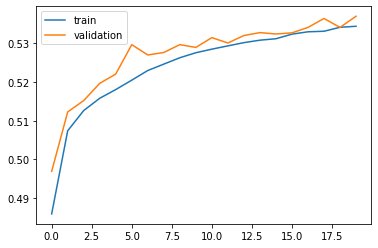

In [78]:
plt.plot(gru.history['accuracy'])
plt.plot(gru.history['val_accuracy'])
plt.legend(['train','validation'])
plt.show()

Como se aprecia en el grafico previo, la precisión del modelo aumenta a medida que aumentan los epochs tanto en el conjunto de entrenamiento como en el de validación, con cierta variabilidad en esta última. 
Sin embargo, la mejora respecto al modelo simple no ha sido muy notable, ya que el valor más elevado obtenido ha sido de 0.5353. Esto se puede deber a que las Gated recurrent units (GRUs) suelen sen menos precisas que las LSTM a a pesar de que se ejecutan más rápidamente y ocupen menos memoria. Suelen ser más eficientes en bases de datos de menor tamaño.

## Bidirectional GRU

El siguiente modelo que se ha probado ha sido una RNN bidireccional. Las redes neuronales recurrentes bidireccionales (RNN) no son más que la unión de dos RNN independientes. La secuencia de entrada se alimenta en el orden temporal normal para una red, y en el orden temporal inverso para la otra. Las salidas de las dos redes suelen concatenarse en cada paso de tiempo

Al procesar una secuencia en ambos sentidos, una RNN bidireccional puede captar patrones que pueden ser que una RNN unidireccional podría pasar por alto.

In [165]:
def bd_model(input_shape, output_sequence_length, english_vocab_size, spa_vocab_size):
   
    learning_rate = 1e-3
    model = Sequential()
    model.add(Bidirectional(GRU(128, return_sequences = True, dropout = 0.1), 
                           input_shape = input_shape[1:]))
    model.add(TimeDistributed(Dense(spa_vocab_size, activation = 'softmax')))
    model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = Adam(learning_rate), 
                 metrics = ['accuracy'])
    return model


In [166]:
tmp_x = trainX.reshape((trainX.shape[0],trainX.shape[1],1))

bidi_model = bd_model(
    tmp_x.shape,
    max_spanish_sequence_length,
    eng_vocab_size,
    spa_vocab_size)
bidiGru = bidi_model.fit(tmp_x, trainY, batch_size=512, epochs=20, validation_split=0.2)

Epoch 1/20
63/63 [==============================] - 232s 4s/step - loss: 7.2274 - accuracy: 0.4086 - val_loss: 3.5244 - val_accuracy: 0.5009
Epoch 2/20
63/63 [==============================] - 221s 3s/step - loss: 3.4258 - accuracy: 0.5024 - val_loss: 3.3598 - val_accuracy: 0.5111
Epoch 3/20
63/63 [==============================] - 217s 3s/step - loss: 3.3040 - accuracy: 0.5093 - val_loss: 3.2978 - val_accuracy: 0.5137
Epoch 4/20
63/63 [==============================] - 217s 3s/step - loss: 3.2450 - accuracy: 0.5106 - val_loss: 3.2491 - val_accuracy: 0.5158
Epoch 5/20
63/63 [==============================] - 222s 4s/step - loss: 3.1822 - accuracy: 0.5143 - val_loss: 3.2107 - val_accuracy: 0.5170
Epoch 6/20
63/63 [==============================] - 218s 3s/step - loss: 3.1396 - accuracy: 0.5167 - val_loss: 3.1768 - val_accuracy: 0.5193
Epoch 7/20
63/63 [==============================] - 220s 3s/step - loss: 3.1109 - accuracy: 0.5175 - val_loss: 3.1492 - val_accuracy: 0.5225
Epoch 8/20
63

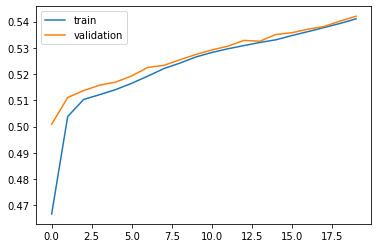

In [167]:
plt.plot(bidiGru.history['accuracy'])
plt.plot(bidiGru.history['val_accuracy'])
plt.legend(['train','validation'])
plt.show()

Con los mismo hiperparámetros de entrada, con este modelo bidireccional con capas GRU, se ha conseguido aumentar el accuracy a un 0.5420.

In [46]:
#save the model
import os
import glob
 
if not os.path.exists("models"):
    os.makedirs("models")
 

cache_dir = os.path.join("models")
model_file = "bidi_model.h5"
bidi_model.save(os.path.join(cache_dir, model_file))
 
os.path.join(cache_dir, model_file)


'models\\bidi_model.h5'

## Bidirectinal LSTM

Ya hemos visto que una RNN bidireccional ha proporcionado mejores resultados que un RNN unidireccional, al igual que La capa LSTM parece más apropiada que la GRU para este casos. Por todo ello, se genera un último modelo RNN bidireccional con capas LSTM.

In [154]:
def bd_model2(input_shape, output_sequence_length, spanish_vocab_size, english_vocab_size):
    """
    Build and train a bidirectional RNN model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement
    
    learning_rate = 0.001
    embedding_size = 256
    
    spanish_input = Input(shape=input_shape[1:], name="input_layer")  # input to LSTM shape (batch, seq_length, 1)
    
    x = Bidirectional(LSTM(64, return_sequences=True, activation="tanh", name="Bidir_LSTM_layer"), input_shape=input_shape[1:])(spanish_input)
    
    preds = TimeDistributed(Dense(spanish_vocab_size, activation="softmax"), name="Dense_layer")(x)
    
    model = Model(inputs=spanish_input, outputs=preds, name='Bidir_LSTM')
    
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    
    return model

In [155]:
# TODO: Train and Print prediction(s)

# TODO: Reshape the input
tmp_x = trainX.reshape((trainX.shape[0],trainX.shape[1],1))  # reshape to (batch, seq_length, 1) for LSTM input

# Train the neural network
bd_rnn_model2 = bd_model2(
                        tmp_x.shape,
                        max_spanish_sequence_length,
                        eng_vocab_size,
                        spa_vocab_size)

bd_rnn_model2.summary()
    
bd2 = bd_rnn_model2.fit(tmp_x, trainY, batch_size=256, epochs=20, validation_split=0.2)

Model: "Bidir_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 8, 1)]            0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 8, 128)            33792     
_________________________________________________________________
Dense_layer (TimeDistributed (None, 8, 6942)           895518    
Total params: 929,310
Trainable params: 929,310
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
125/125 [==============================] - 100s 762ms/step - loss: 6.8731 - accuracy: 0.3522 - val_loss: 3.4203 - val_accuracy: 0.5044
Epoch 2/20
125/125 [==============================] - 93s 748ms/step - loss: 3.3272 - accuracy: 0.5086 - val_loss: 3.2922 - val_accuracy: 0.5102
Epoch 3/20
125/125 [==============================] - 102s 818ms/step - loss: 3.2264 - ac

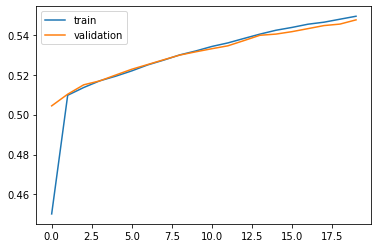

In [158]:
plt.plot(bd2.history['accuracy'])
plt.plot(bd2.history['val_accuracy'])
plt.legend(['train','validation'])
plt.show()

Con este modelo se obtiene un accuracy de 0.5475, ligeramente superior al Bidireccional que utiliza capas GRU, como era de esperar.

Tras probar con modelos distintos con distintas arquitecturas y complejidades, se puede concluir que modelo Seq2Seq es el que mejores resultados obtiene, en cuanto a precisión. Esto se debe a que es un modelo muy potente utilizado para la traducción de textos, que cuenta con una arquitectura con capas LSTM que permiten resolver las dependencias a largo plazo y pueden memorizar
datos anteriores fácilmente, muy útil para dataset grandes.

Por tanto, se utiliza este modelo para hacer las predicciones.

## Make Predictions
Let's load the saved model to make predictions.

In [43]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

C:\Users\Maria\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [45]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [46]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [47]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [48]:
pd.set_option('display.max_colwidth', 200)

In [49]:
pred_df.head(15)

,actual,predicted
0,they are very cheerful,theyre very
1,i know tom,i know tom
2,you may refuse,you may
3,thats private,thats is
4,tom leaped from his seat,tom has the
5,have you ever sold a car,ill you to a car
6,how many kids do you have,how do you
7,i will not let you do it,i dont you to you
8,isnt it beautiful,is beautiful
9,my parrot died yesterday,my was


In [50]:
pred_df.tail(15)

,actual,predicted
9985,do tom and mary know,what tom to
9986,tom can be clumsy,tom might be
9987,do you want to try it,do you want to
9988,do you know who he was,do you know this
9989,shes also a beauty,its a good
9990,i love your daughter,i want my
9991,he teaches english,he is in
9992,i overslept,i was her
9993,he is as poor as can be,he is as
9994,wheres my shirt,wheres your


In [51]:
pred_df.sample(15)

,actual,predicted
2312,whos that man over there,thats is this here
2607,i had to keep my secret,i had to a
8924,she should eat breakfast,she never him
7090,do you want to touch it,do you want to it
762,i was abducted,i was
8013,when did they go home,how did i home
2279,tom worked there,tom was french
7822,i never told you to quit,i dont i to
2874,theyll find tom,they tom
2875,tom is still sleeping,tom is


Se puede apreciar que el modelo no traduce muy bien las distintas frases, esto se debe a que la precisión obtenida del casi 63% no es muy óptima, se podría probar para estudios futuros cambiar el batch size y aumentar el número de épocas, ya que 20 vueltas completas por el dataset es un número pequeño para el caso de uso del modelo.